In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
#os.environ['XLA_FLAGS'] = "--xla_force_host_platform_device_count=8"
import jax
#jax.config.update("jax_platform_name", "cpu")

from jax import numpy as jnp
from jax.experimental import host_callback
from flax import struct
from flax.core import frozen_dict

from tqdm.auto import tqdm
from functools import partial
import optax
import matplotlib.pyplot as plt

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
import frozen_lake
import utils
import qlearning
import plotting
import replay

/home/davide_sartor/.local/lib/python3.10/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [10]:
seed = 42
map_size = 8

# hyperparams
# lr fixed to 1e-3
max_interactions = 256 * 1000
rollout_length = 256  # * (map_size ** 2 --- map_size ** 3)
n_rollouts = max_interactions // rollout_length
train_iter = 8  # *
eps_annealing = optax.cosine_decay_schedule(1.0, train_iter * n_rollouts // 2, 0.1)  # * *

# setup
env = frozen_lake.FrozenLake((map_size, map_size))
qnet = utils.ConvNet(hidden=[2 * map_size] * int(jnp.log2(map_size)), out=4)


rollout = utils.get_rollout_fn(env, utils.eps_greedy_policy(qnet.apply))

TypeError: Module.tabulate() missing 1 required positional argument: 'rngs'

In [5]:
def initialize_state(rng_key: jax.Array):
    rng_env_init, rng_env_reset, rng_qnet = jax.random.split(rng_key, 3)
    env_params = env.init(rng_env_init)
    env_state, env_obs = env.reset(env_params, rng_env_reset)

    qnet_params = qnet.init(rng_qnet, env_obs)
    train_state = qlearning.DDQNTrainState.create(apply_fn=qnet.apply, params=qnet_params)

    init_transitions = rollout(env_params, train_state.params, 1.0, rng_key, rollout_length)
    replay_memory = replay.CircularBuffer.create(init_transitions)
    return env_params, train_state, replay_memory


def run_sim(rng_key: jax.Array):
    rng_init, rng_loop = jax.random.split(rng_key)
    env_params, train_state, replay_memory = initialize_state(rng_init)

    def loop_body(carry, rng_key):
        train_state, replay_memory = carry

        # bind progress bar update host callback to rng_key split
        rng_expl, rng_train, rng_eval = host_callback.id_tap(
            lambda a, t: pbar.update(1), jax.random.split(rng_key, 3)
        )

        # exploration rollout
        expl_transitions = rollout(
            env_params,
            train_state.params,
            rng_key=rng_expl,
            epsilon=eps_annealing(train_state.step),
            n_steps=rollout_length,
        )
        replay_memory = replay_memory.push(expl_transitions)

        # policy training
        for rng_sample in jax.random.split(rng_train, train_iter):
            train_transitions = replay_memory.sample(rng_sample, rollout_length)
            grads = train_state.td_gradient(train_transitions)
            train_state = train_state.apply_updates(grads)

        # evaluation rollout
        eval_transitions = rollout(
            env_params,
            train_state.params,
            rng_key=rng_eval,
            epsilon=0.0,
            n_steps=rollout_length,
        )
        return (train_state, replay_memory), (eval_transitions.reward, eval_transitions.done)

    pbar = tqdm(total=n_rollouts)
    (train_state, replay_memory), eval = jax.lax.scan(
        loop_body,
        (train_state, replay_memory),
        jax.random.split(rng_loop, n_rollouts),
    )
    pbar.close()
    return train_state, eval

In [6]:
rng_key = jax.random.PRNGKey(seed)
train_state, eval_trans = jax.vmap(run_sim)(jax.random.split(rng_key, 8))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
rewards, done = eval_trans

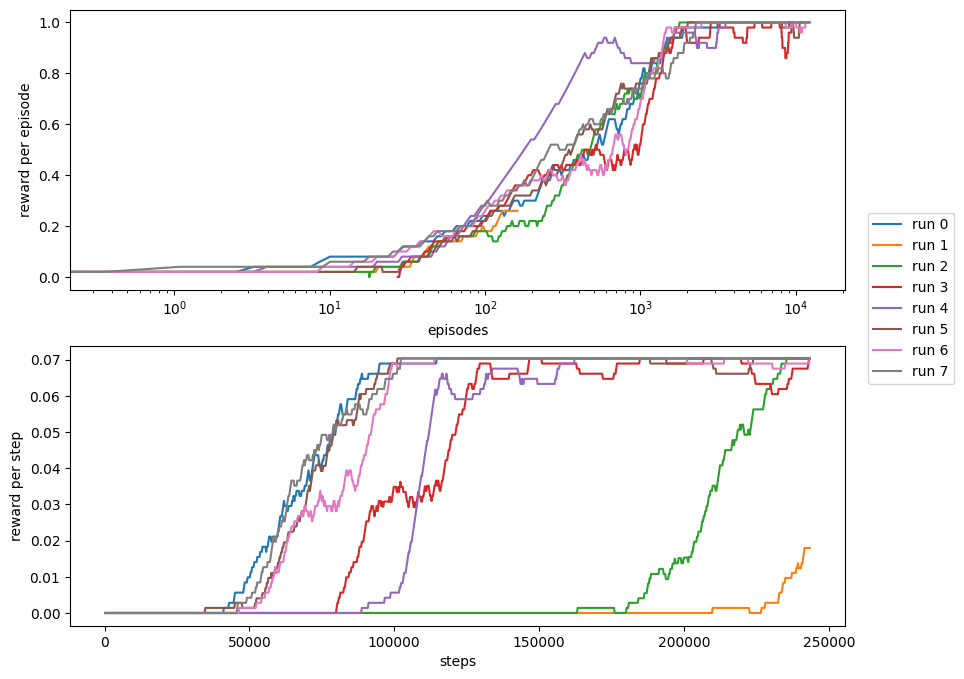

In [8]:
def smooth(r, w=50):
    filter = jnp.ones(w) / w
    return jnp.convolve(r, filter, mode="valid")


avg_done = done.mean(axis=0).sum(axis=-1)
avg_reward = rewards.mean(axis=0).sum(axis=-1)
plt.figure(figsize=(10, 8))
for i, (r, n) in enumerate(zip(rewards.sum(axis=-1), done.sum(axis=-1))):
    plt.subplot(211)
    plt.semilogx(smooth(jnp.cumsum(n)), smooth(jnp.where(n > 0, r / n, 0)), label=f"run {i}")
    plt.ylabel("reward per episode")
    plt.xlabel("episodes")
    plt.subplot(212)
    r = smooth(r) / rewards.shape[-1]
    plt.plot(256*jnp.arange(1,1+len(r)), r, label=f"run {i}")
    plt.ylabel("reward per step")
    plt.xlabel(f"steps")
plt.legend(bbox_to_anchor=(1.15, 1.5))

100%


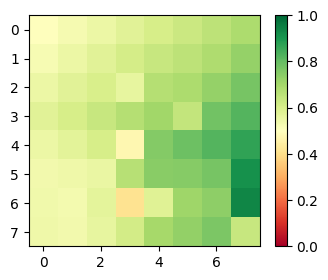

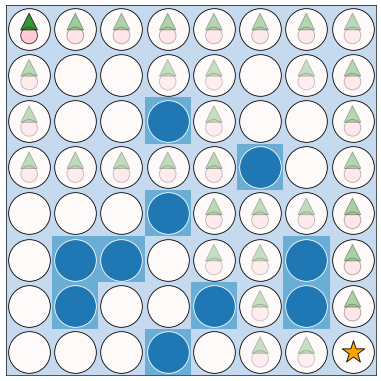

In [9]:
env_params, _, _ = initialize_state(rng_key)
get_qval = lambda p, o: jax.vmap(qnet.apply, in_axes=(0, None))(p, o).mean(axis=0)

batch_rollout = jax.vmap(partial(rollout, env_params, rng_key=rng_key, epsilon=0.0, n_steps=30))
transitions = batch_rollout(train_state.params)
transitions = jax.tree_map(lambda x: x.reshape(-1, *x.shape[2:]), transitions)

plotting.plot_qvals(env, env_params, get_qval, train_state.params)
plotting.render(transitions.env_state, env_params)
if transitions.done.sum() > 0:
    print(f"{int(100*transitions.reward.sum()/transitions.done.sum())}%")
else:
    print("No success")